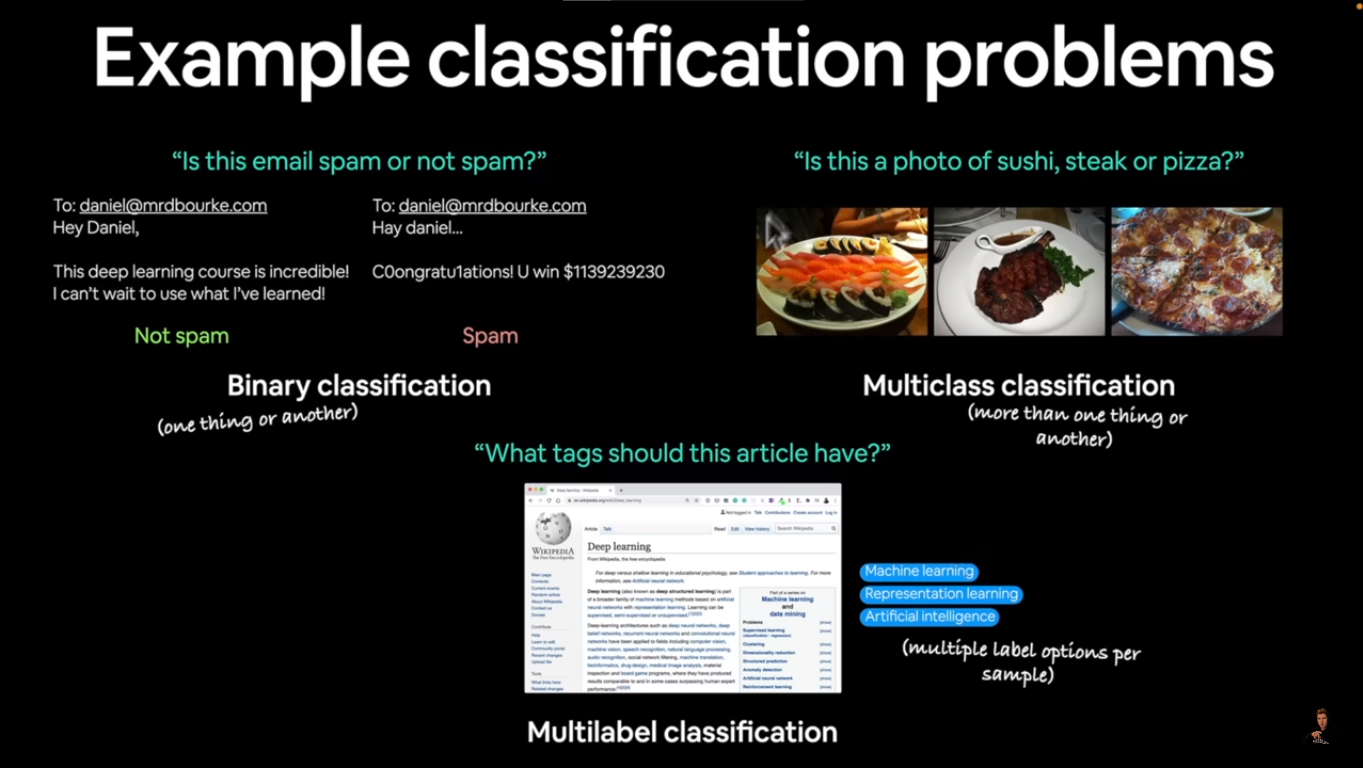

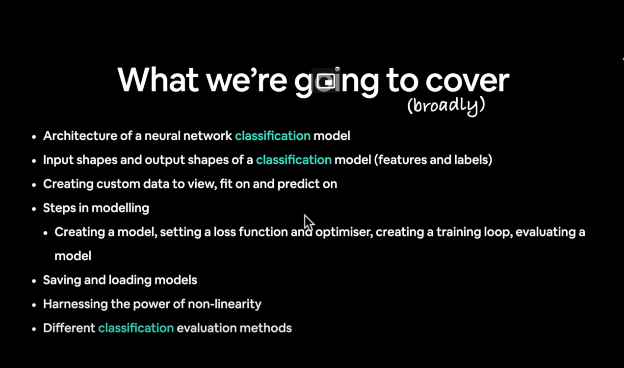

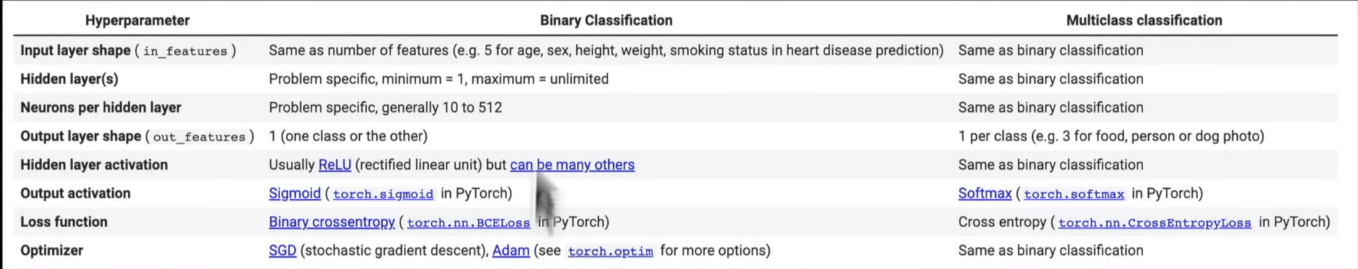

## 1. Make classification data and get it ready

In [37]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_sample = 1000

# Create circles
X , y= make_circles(n_sample,
                    noise = 0.03,
                    random_state = 42)


In [38]:
len(X), len(y)

(1000, 1000)

In [39]:
#Make dataFrame of circle data

import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:, 1,], "label":y})

In [40]:
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


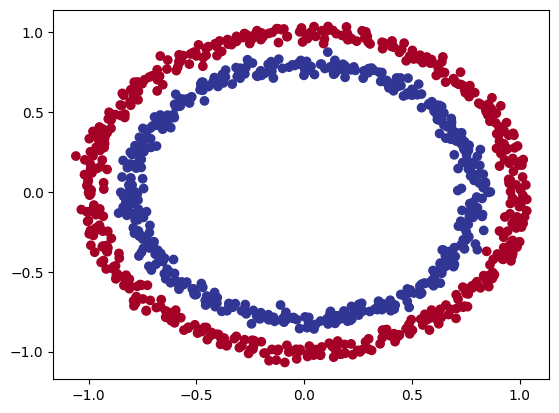

In [41]:
# Visualize, Visualize, Visualize!

import matplotlib.pyplot as plt
plt.scatter(X[:,0], y=X[:,1], c = y, cmap=plt.cm.RdYlBu)

# Check input ant output shapes

In [42]:
X.shape, y.shape # X: 2 feature, Y: is a scalar

((1000, 2), (1000,))

In [43]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print("Value: " ,X_sample, "the same for y: " , y_sample)
"Shapes of X: ", X_sample.shape, "The same for y: ", y_sample.shape

Value:  [0.75424625 0.23148074] the same for y:  1


('Shapes of X: ', (2,), 'The same for y: ', ())

Turn data into tensors and create train and test split

In [44]:
#Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [45]:
type(X), type(y)

(torch.Tensor, torch.Tensor)

In [46]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
* Setup device agonistic code
* Construct a model (by subclassing 'nn_Module')
* Define a loss function and optimizer
* Create a training and test loop

In [47]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclass 'nn.Module'
2. Create 2 'nn.Linear()' layers that are capable of handling the shapes of our data
3. Define a 'forward()' method that outlines the forward pass or forward computatioın of the modeol
4. Instatiate an instance of our model class and send it to the target device

In [48]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5) # out_features can have arbitrary number
    #in_features // X_train has 2 feature
    #out_features // y_train is a scalar and 1 dim
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)
    #in_features in self.layer_2 must match out_features in self.layer_1

  # Define a forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x))   # x -> layer_1 -> layer_2 -> output

  # Instantiate an instance of our model class and send it to the target device

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [49]:
next(model_0.parameters()).device

device(type='cpu')

Easiest way to build a classification model

In [50]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5 ),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [51]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [52]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

In [53]:
print(f"Length of prediction: ", len(untrained_preds))
print(f"Shape: ", untrained_preds.shape)
print("First 10 predictions\n",torch.round(untrained_preds[:10]), "\n First 10 labels", y_test[:10])

Length of prediction:  200
Shape:  torch.Size([200, 1])
First 10 predictions
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]]) 
 First 10 labels tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Setup loss function and optimizer

##### As a reminder the loss function measure how wrong our model is
##### What is logits layers: The layer that feeds in to softmax (or other such normalization)
#####And for optimizers, two of the most common and useful are SGD and Adam in PyTorch

##### For the loss function we're going tou use "torch.nn.BECWithLogitsLoss()"

In [54]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() #Sigmoid activation built-in
#nn.BCEWithLogitsLoss() = nn.Sequential(nn.Sigmoid(), nn.BCELoss())

optimizer = torch.optim.SGD(params = model_0.parameters(),lr = 0.01)

In [55]:
# Calculate accuracy - out of 100 example, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### Going from raw logits -> Prediction probability - Prediction labels

Our model outputs are going to be raw **logits**


We can convert these **logits** into prediction probabilitiyes by passing them to soem kind of activation function (e.g. sigmoid for binary classification and softmax for multicalss classifciation).

Then we can covert our model's prediction probabilities to **prediction labels** by either rounding them or taking the 'argmax()'

In [56]:
#View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [57]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [58]:
# We need y_logits like y_test, use the sigmoid function
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

For our prediction probability values, we need to perform a range-style rounding on them:
* 'y_pred_probs' >= 0.5, y = 1
* 'y_pred_probs' <= 0.5  y = 0

In [59]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [60]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [61]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

> What did we do?

* We take the raw model output samples (logits // y_logits)
* We apply sigmoid function for consistency
* We apply round function for ranging between 0 to 1 (y_preds)

# Building a training and testing loop

In [62]:
torch.manual_seed(42)

epochs = 100

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)

  # loss = loss_fn(torch.sigmoid(y_logits), y_train) --> nn.BCELoss

  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)

  # Optimizer zero grad
  optimizer.zero_grad()

  loss.backward() # --> Backpropogation

  optimizer.step() # --> Gradient Descent

  #### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)


    if epoch % 10 == 0:
      print(f"Epoch: {epoch} l   Loss:  {loss:.5f} l, Acc: {acc:.2f}, Test loss {test_loss:.5f}, Test acc: {test_acc:5f}")


Epoch: 0 l   Loss:  0.69796 l, Acc: 51.88, Test loss 0.69460, Test acc: 57.500000
Epoch: 10 l   Loss:  0.69768 l, Acc: 52.00, Test loss 0.69438, Test acc: 58.000000
Epoch: 20 l   Loss:  0.69742 l, Acc: 52.00, Test loss 0.69418, Test acc: 57.500000
Epoch: 30 l   Loss:  0.69717 l, Acc: 52.00, Test loss 0.69401, Test acc: 56.500000
Epoch: 40 l   Loss:  0.69695 l, Acc: 51.62, Test loss 0.69385, Test acc: 56.500000
Epoch: 50 l   Loss:  0.69675 l, Acc: 51.38, Test loss 0.69370, Test acc: 56.000000
Epoch: 60 l   Loss:  0.69656 l, Acc: 51.38, Test loss 0.69357, Test acc: 56.000000
Epoch: 70 l   Loss:  0.69638 l, Acc: 51.38, Test loss 0.69345, Test acc: 56.500000
Epoch: 80 l   Loss:  0.69621 l, Acc: 51.25, Test loss 0.69334, Test acc: 56.500000
Epoch: 90 l   Loss:  0.69606 l, Acc: 51.38, Test loss 0.69324, Test acc: 55.000000


In [63]:
# Make predictions and evaluate the model

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("Already exists!")
else:
  print("Downloading")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Already exists!


In [64]:
import helper_functions as hf

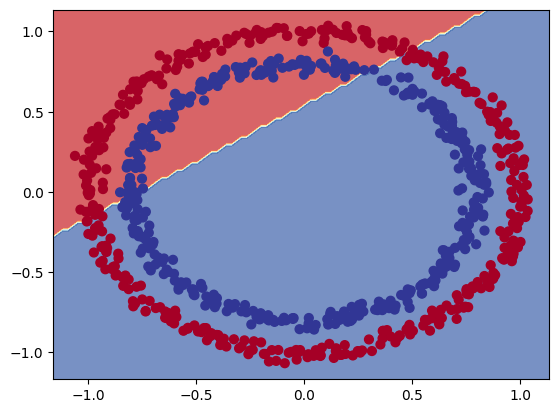

In [65]:
hf.plot_decision_boundary(model_0,X_train,y_train)

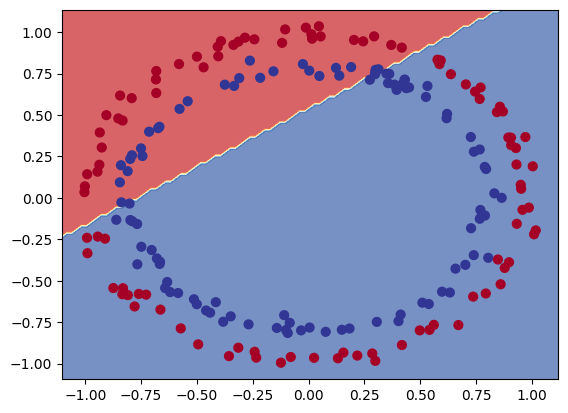

In [66]:
hf.plot_decision_boundary(model_0,X_test,y_test)

Improving a model

*  Add more layers
*  Add more data
*  Add more hidden units
*  Fit for longer
*  Changing the activation functions
*  Change the learning rate
*  Change the loss function


Smaller Model to Larger Model:

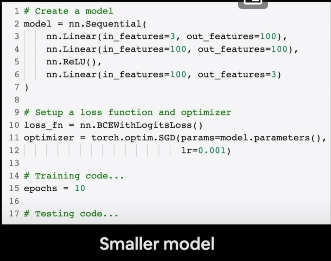

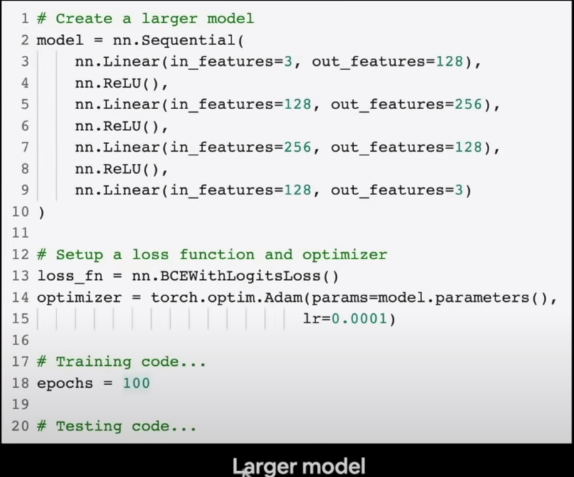

In [67]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features=10 )
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1) #Output

  def forward(self, x):
    z = self.layer_1(x)
    z = self.layer_2(z)
    z = self.layer_3(z)
    return z


In [68]:
model_1 = CircleModelV1().to(device)

In [69]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [70]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

In [71]:
# Write a training and evaluation loop for model_1

torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits , y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_test, test_pred)


  if epoch & 100 == 0:
    print(f"Epoch: {epoch}, Loss: {loss:5f}, Acc: {acc:2f}, Test loss: {test_loss:5f}, Test acc: {test_acc:2f}")


Epoch: 0, Loss: 0.693955, Acc: 50.875000, Test loss: 0.692611, Test acc: 51.000000
Epoch: 1, Loss: 0.693952, Acc: 50.875000, Test loss: 0.692611, Test acc: 51.000000
Epoch: 2, Loss: 0.693948, Acc: 50.750000, Test loss: 0.692611, Test acc: 51.000000
Epoch: 3, Loss: 0.693945, Acc: 50.750000, Test loss: 0.692612, Test acc: 51.000000
Epoch: 8, Loss: 0.693929, Acc: 50.625000, Test loss: 0.692614, Test acc: 51.000000
Epoch: 9, Loss: 0.693925, Acc: 50.625000, Test loss: 0.692615, Test acc: 51.000000
Epoch: 10, Loss: 0.693922, Acc: 50.500000, Test loss: 0.692615, Test acc: 51.000000
Epoch: 11, Loss: 0.693919, Acc: 50.625000, Test loss: 0.692616, Test acc: 51.000000
Epoch: 16, Loss: 0.693904, Acc: 50.625000, Test loss: 0.692619, Test acc: 50.500000
Epoch: 17, Loss: 0.693900, Acc: 50.625000, Test loss: 0.692619, Test acc: 50.500000
Epoch: 18, Loss: 0.693897, Acc: 50.625000, Test loss: 0.692620, Test acc: 50.500000
Epoch: 19, Loss: 0.693894, Acc: 50.625000, Test loss: 0.692620, Test acc: 50.50000

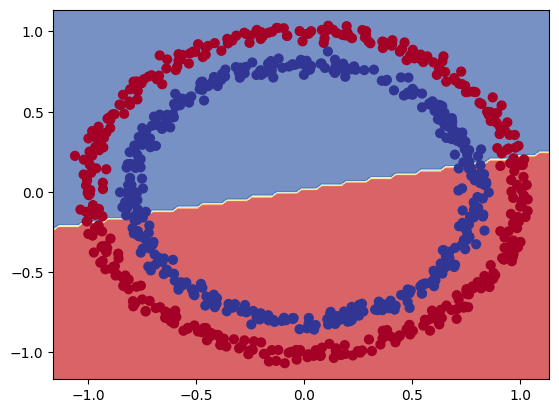

In [72]:
hf.plot_decision_boundary(model_1, X_train,y_train)

NON-LINEARITY!

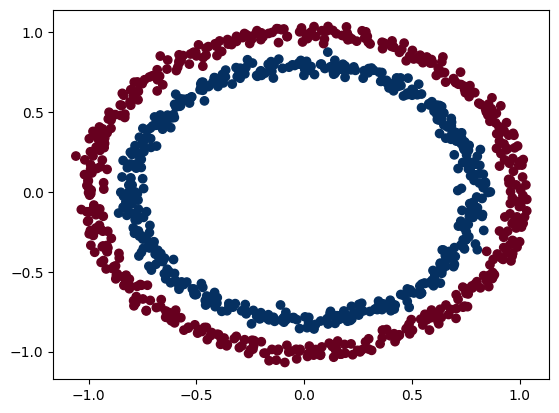

In [74]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

plt.scatter(X[:,0], X[:,1], c = y, cmap=plt.cm.RdBu)

In [77]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split
X_train ,X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2,
                                                   random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# Building a model with non-linearity

In [79]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features =1)
    self.relu =nn.ReLU() #ReLU is a non-linear activation function


  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [80]:
# setup loss and optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr = 0.1)

# Training a model with non-linearity

In [86]:
torch.manual_seed(42)

# Put all data on target device
X_train, y_train =  X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Loops

epochs = 2000

for epoch in range(epochs):
  #TRAIN
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # Logits -> Prediction Prob -> Prediction labels

  loss = loss_fn(y_logits, y_train) #BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true= y_train,
                    y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  #TEST
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)


  if epoch % 100 == 0:
    print(f"Epoch:{epoch}, Loss: {loss:4f}, Acc: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}")









Epoch:0, Loss: 0.566729, Acc: 88.00%, Test Loss: 0.5725, Test Acc: 86.50
Epoch:100, Loss: 0.479500, Acc: 93.62%, Test Loss: 0.4977, Test Acc: 90.00
Epoch:200, Loss: 0.368223, Acc: 98.00%, Test Loss: 0.4039, Test Acc: 92.50
Epoch:300, Loss: 0.252533, Acc: 99.00%, Test Loss: 0.3013, Test Acc: 96.50
Epoch:400, Loss: 0.170531, Acc: 99.50%, Test Loss: 0.2198, Test Acc: 97.50
Epoch:500, Loss: 0.121110, Acc: 99.75%, Test Loss: 0.1642, Test Acc: 99.00
Epoch:600, Loss: 0.090742, Acc: 99.88%, Test Loss: 0.1268, Test Acc: 99.50
Epoch:700, Loss: 0.070684, Acc: 99.88%, Test Loss: 0.1028, Test Acc: 99.50
Epoch:800, Loss: 0.057517, Acc: 99.88%, Test Loss: 0.0864, Test Acc: 99.50
Epoch:900, Loss: 0.048371, Acc: 99.88%, Test Loss: 0.0745, Test Acc: 99.50
Epoch:1000, Loss: 0.041643, Acc: 99.88%, Test Loss: 0.0657, Test Acc: 100.00
Epoch:1100, Loss: 0.036180, Acc: 99.88%, Test Loss: 0.0597, Test Acc: 100.00
Epoch:1200, Loss: 0.031972, Acc: 99.88%, Test Loss: 0.0545, Test Acc: 100.00
Epoch:1300, Loss: 0.0

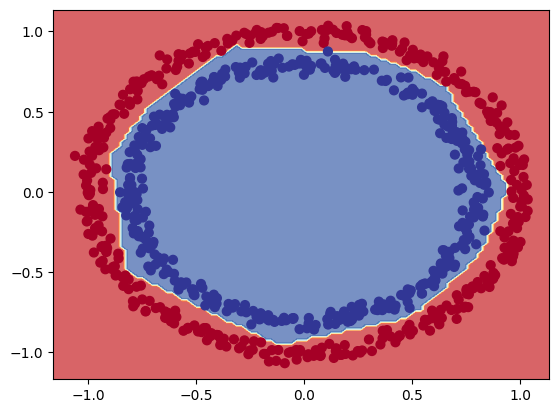

In [87]:
hf.plot_decision_boundary(model_3, X_train, y_train)

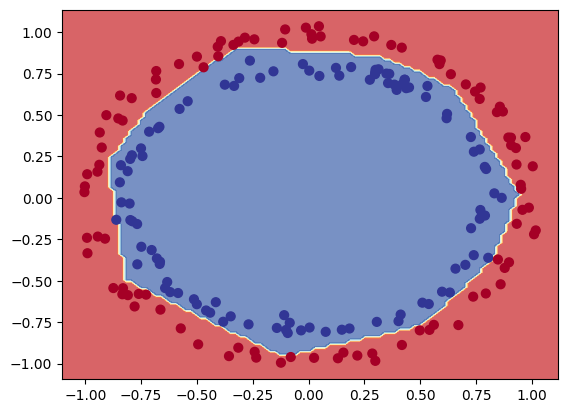

In [88]:
hf.plot_decision_boundary(model_3, X_test, y_test)

In [89]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

In [90]:
y_preds[:4]

tensor([1., 0., 1., 0.])

# Replicating non-linear activation functions



In [96]:
# Create a tensor
A = torch.arange(-10,10,1,dtype=torch.float32)
A.dtype

torch.float32

In [97]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

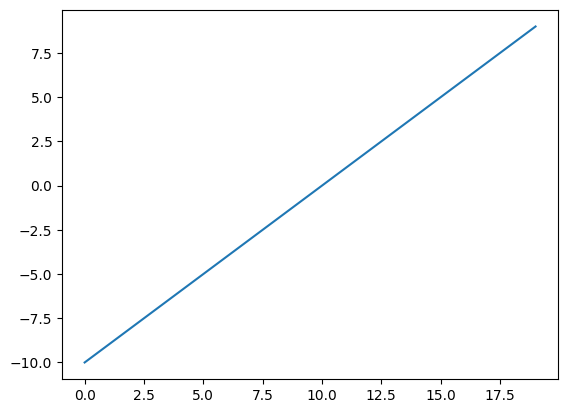

In [98]:
plt.plot(A)

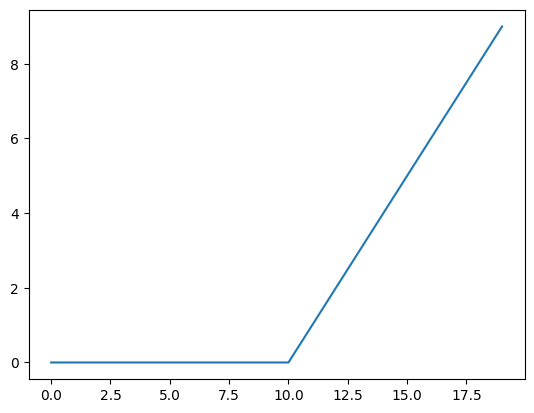

In [101]:
plt.plot(torch.relu(A))